# Sampled training without weighted loss

"Ihre Aufgabe besteht in der Modellierung der zu erwartenden Schadenhöhe pro Versicherungsnehmer und Jahr anhand der Risikomerkmale der Kunden. Dieser Wert ist Basis für die Berechnung eines fairen Versicherungsbeitrags."

i did not remove any outliers during feature engineering because they are still valid but rare, and not invalid. This is why I will only use non-linear models and not something like linear regression.

the first model that comes to my mind when using tabular data like this is XGBoost or Random Forest. Neural Networks (MLP) might work too, so we will give it a try.

In [1]:
import numpy as np
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample

In [2]:
feature_names = ["ClaimNb", "Exposure", "Area", "VehPower", "VehAge", "DrivAge", "BonusMalus", "VehBrand", "VehGas", "Density", "Region"]

In [3]:
np.set_printoptions(suppress=True)

In [4]:
X = np.load("data/X.npy")
y = np.load("data/y.npy")
w = np.load("data/w.npy")

In [5]:
majority_indices = np.where(y == 0)[0]
# Find the indices of the minority class
minority_indices = np.where(y != 0)[0]
# Resample the majority indices with replacement
resampled_majority_indices = resample(majority_indices,
                                      replace=True,
                                      n_samples=len(minority_indices),
                                      random_state=42)
# Combine the resampled majority indices with the minority indices
resampled_indices = np.concatenate([resampled_majority_indices, minority_indices])
# Use the resampled indices to balance the X, y and w arrays
X_resampled = X[resampled_indices]
y_resampled = y[resampled_indices]
w_resampled = w[resampled_indices]

In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X_resampled, y_resampled, w_resampled, test_size=0.3, random_state=42)

In [7]:
print("Train set: ", len(X_train))
print("Test set: ", len(X_test))

Train set:  34921
Test set:  14967


In [8]:
def weighted_mse(outputs, targets, weights):
    return (weights * (outputs - targets)**2).mean()

### random forest

In [9]:
rf = RandomForestRegressor(n_estimators=100, random_state=42, criterion="friedman_mse")

In [10]:
rf.fit(X_train, y_train)

RandomForestRegressor(criterion='friedman_mse', random_state=42)

In [11]:
rf_predictions = rf.predict(X_test)

In [12]:
print("sample input: ", X_test[0], "Sample prediction: ", rf_predictions[0])

sample input:  [0.125      0.11820434 0.4        0.         0.02       0.14634146
 0.16666667 0.         0.         0.16100596 0.0952381 ] Sample prediction:  0.0007741413615161834


In [13]:
print("Random Forest MSE: ", '{:f}'.format(weighted_mse(rf_predictions, y_test, w_test)))

Random Forest MSE:  3248.638887


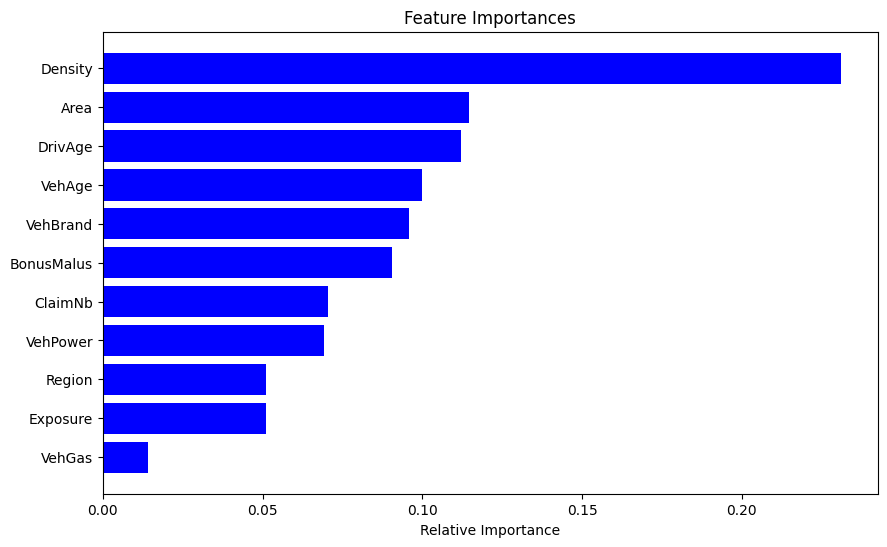

In [14]:
feature_importances = rf.feature_importances_
indices = np.argsort(feature_importances)

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### XGBoost

In [15]:
xgb = XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75, colsample_bytree=1, max_depth=7)

In [16]:
xgb.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.08, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [17]:
xgb_predictions = xgb.predict(X_test)

In [18]:
print("XGBoost MSE: ", '{:f}'.format(weighted_mse(xgb_predictions, y_test, w_test)))

XGBoost MSE:  5504.282188


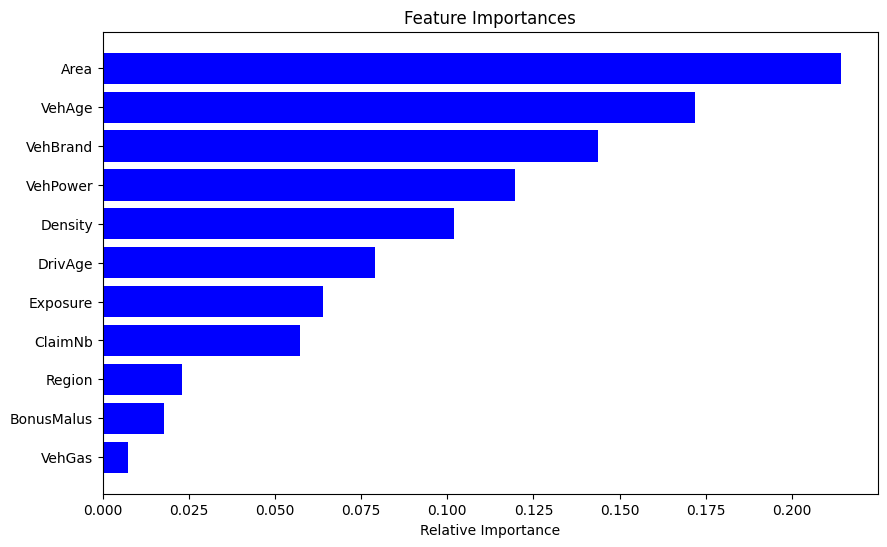

In [19]:
feature_importances = xgb.feature_importances_
indices = np.argsort(feature_importances)

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Neural Network

In [20]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.float)
w_train_tensor = torch.tensor(w_train, dtype=torch.float)
X_test_tensor = torch.tensor(X_test, dtype=torch.float)

In [21]:
train_data = TensorDataset(X_train_tensor, y_train_tensor, w_train_tensor)

In [22]:
train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)

In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [24]:
model = nn.Sequential(
    nn.Linear(X_train.shape[1], 32),
    nn.ReLU(),
    nn.Linear(32, 32),
    nn.ReLU(),
    nn.Linear(32, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 1)
).to(device)

In [25]:
optimizer = torch.optim.AdamW(model.parameters())

In [26]:
for epoch in range(3):  # Adjust the number of epochs as needed
    for inputs, targets, weights in train_loader:
        # Forward pass
        outputs = model(inputs.to(device)).to("cpu")
        loss = ((outputs - targets)**2).mean()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Finished epoch ", epoch+1)

Finished epoch  1
Finished epoch  2
Finished epoch  3


In [27]:
with torch.no_grad():
    nn_predictions = model(X_test_tensor.to(device)).to("cpu")

In [28]:
print("Neural Network MSE: ", '{:f}'.format(weighted_mse(np.array(nn_predictions.squeeze()), y_test, w_test)))

Neural Network MSE:  2330.247916


## Results

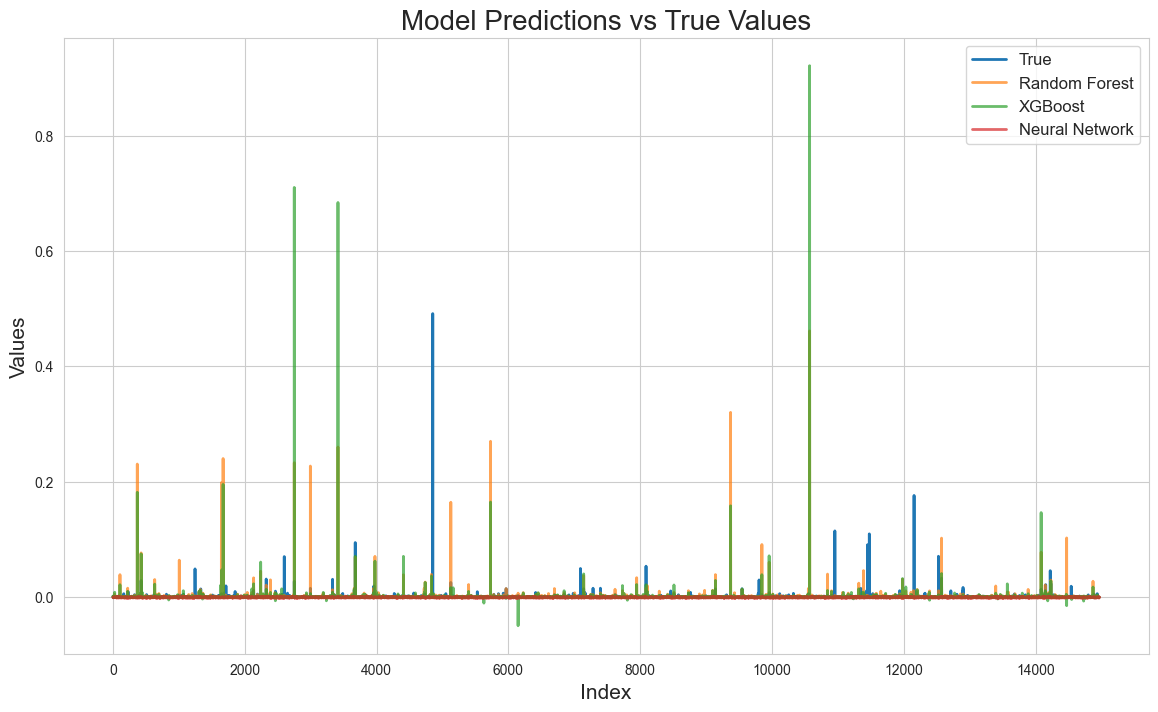

In [29]:
# Set the style of seaborn for better visuals
sns.set_style("whitegrid")

# Create a larger figure
fig, ax = plt.subplots(figsize=(14, 8))

# Plot the data with better line width and opacity
ax.plot(y_test, label='True', linewidth=2)
ax.plot(rf_predictions, label='Random Forest', linewidth=2, alpha=0.7)
ax.plot(xgb_predictions, label='XGBoost', linewidth=2, alpha=0.7)
ax.plot(nn_predictions, label='Neural Network', linewidth=2, alpha=0.7)

# Add title and labels with larger font sizes
ax.set_title('Model Predictions vs True Values', fontsize=20)
ax.set_xlabel('Index', fontsize=15)
ax.set_ylabel('Values', fontsize=15)

# Increase the font size of legend
ax.legend(fontsize=12)

# Show grid lines for better reference
ax.grid(True)

# Display the plot
plt.show()

In [30]:
print("Random Forest MSE: ", '{:f}'.format(weighted_mse(rf_predictions, y_test, w_test)))
print("XGBoost MSE: ", '{:f}'.format(weighted_mse(xgb_predictions, y_test, w_test)))
print("Neural Network MSE: ", '{:f}'.format(weighted_mse(np.array(nn_predictions.squeeze()), y_test, w_test)))

Random Forest MSE:  3248.638887
XGBoost MSE:  5504.282188
Neural Network MSE:  2330.247916
